# Segment the adult dataset using GOWER similarity and DBScan Clustering

In [1]:
%matplotlib inline
import pickle

# data processing
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.outliers import Winsorizer

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
import gower
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Supervised Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Model Evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Cluster Explainability
import shap





In [2]:
#sns.set_theme(style="darkgrid")

# Import Data
the dataset is available here: https://archive.ics.uci.edu/ml/datasets/adult

In [3]:

try:
        # load the local dataset 
        df = pd.read_csv('../data/adult_dataset.csv')
except:
        # load the dataset from uci
        features = ["Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
                "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
                "Hours per week", "Country", "Target"] 

        # Change these to local file if available
        train_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
        test_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

        # This will download 3.8M
        original_train = pd.read_csv(train_url, names=features, sep=r'\s*,\s*', 
                                engine='python', na_values="?")
        # This will download 1.9M
        original_test = pd.read_csv(test_url, names=features, sep=r'\s*,\s*', 
                                engine='python', na_values="?", skiprows=1)

        # combine both datasets
        df = pd.concat([original_train, original_test], axis=0)
        # save the data locally
        df.to_csv('../data/adult_dataset.csv', index=False)                            

In [4]:
df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
# Relabel taget colum since there is no target in unsupervised learning
df.rename(columns={"Target": "Income"}, inplace=True)

In [6]:
#Correct the Income column typo
df['Income'] = df['Income'].apply(lambda x: x.replace('.', ''))

# Train-Test Split the Data

In [7]:
df.shape

(48842, 15)

In [8]:
# way too much data for training; let´s split the data
X_train, X_test = train_test_split(df, test_size=0.8, random_state=123)

In [9]:
X_train.shape

(9768, 15)

In [10]:
X_test.shape

(39074, 15)

In [11]:
X_train.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income
20904,20,Private,194630,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,White,Male,3781,0,50,United-States,<=50K
47239,41,Private,143003,Masters,14,Married-civ-spouse,Tech-support,Husband,Asian-Pac-Islander,Male,0,1887,45,China,>50K
29209,31,Private,210562,HS-grad,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,65,United-States,<=50K
22674,19,Private,67759,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,43,United-States,<=50K
11463,45,Private,241350,HS-grad,9,Never-married,Transport-moving,Not-in-family,White,Male,0,0,40,United-States,<=50K


# Exploratory Data Analysis

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9768 entries, 20904 to 15725
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             9768 non-null   int64 
 1   Workclass       9171 non-null   object
 2   fnlwgt          9768 non-null   int64 
 3   Education       9768 non-null   object
 4   Education-Num   9768 non-null   int64 
 5   Martial Status  9768 non-null   object
 6   Occupation      9171 non-null   object
 7   Relationship    9768 non-null   object
 8   Race            9768 non-null   object
 9   Sex             9768 non-null   object
 10  Capital Gain    9768 non-null   int64 
 11  Capital Loss    9768 non-null   int64 
 12  Hours per week  9768 non-null   int64 
 13  Country         9605 non-null   object
 14  Income          9768 non-null   object
dtypes: int64(6), object(9)
memory usage: 1.2+ MB


In [13]:
X_train.isna().sum()

Age                 0
Workclass         597
fnlwgt              0
Education           0
Education-Num       0
Martial Status      0
Occupation        597
Relationship        0
Race                0
Sex                 0
Capital Gain        0
Capital Loss        0
Hours per week      0
Country           163
Income              0
dtype: int64

## Impute Missing Values

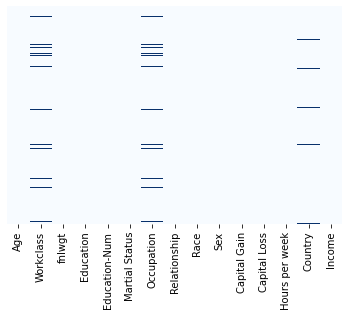

In [14]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

In [15]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

In [16]:
numeric_columns = X_train.select_dtypes(include=numerics).columns.to_list()
numeric_columns

['Age',
 'fnlwgt',
 'Education-Num',
 'Capital Gain',
 'Capital Loss',
 'Hours per week']

In [17]:
categorical_columns = X_train.select_dtypes(exclude=numerics).columns.to_list()
categorical_columns

['Workclass',
 'Education',
 'Martial Status',
 'Occupation',
 'Relationship',
 'Race',
 'Sex',
 'Country',
 'Income']

In [18]:
# Impute missing numeric values
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_numeric = numeric_imputer.fit_transform(X_train.select_dtypes(include=numerics))
X_train_numeric = pd.DataFrame(X_train_numeric, columns=numeric_columns, index=X_train.index)
X_train_numeric.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week
20904,20.0,194630.0,9.0,3781.0,0.0,50.0
47239,41.0,143003.0,14.0,0.0,1887.0,45.0
29209,31.0,210562.0,9.0,0.0,0.0,65.0
22674,19.0,67759.0,9.0,0.0,0.0,43.0
11463,45.0,241350.0,9.0,0.0,0.0,40.0


In [19]:
# Impute missing categorical values
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = categorical_imputer.fit_transform(X_train.select_dtypes(exclude=numerics))
X_train_categorical = pd.DataFrame(X_train_categorical, columns=categorical_columns, index=X_train.index)
X_train_categorical.head()

,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
20904,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,<=50K
47239,Private,Masters,Married-civ-spouse,Tech-support,Husband,Asian-Pac-Islander,Male,China,>50K
29209,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States,<=50K
22674,Private,HS-grad,Never-married,Machine-op-inspct,Own-child,White,Male,United-States,<=50K
11463,Private,HS-grad,Never-married,Transport-moving,Not-in-family,White,Male,United-States,<=50K


In [20]:
# Save imputers both numerical and categorical
with open('../artifacts/numeric_imputer.pickle', 'wb') as filename:
    pickle.dump(numeric_imputer, filename)

with open('../artifacts/categorical_imputer.pickle', 'wb') as filename:
    pickle.dump(categorical_imputer, filename)

In [21]:
X_train = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
20904,20.0,194630.0,9.0,3781.0,0.0,50.0,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,<=50K
47239,41.0,143003.0,14.0,0.0,1887.0,45.0,Private,Masters,Married-civ-spouse,Tech-support,Husband,Asian-Pac-Islander,Male,China,>50K
29209,31.0,210562.0,9.0,0.0,0.0,65.0,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,Male,United-States,<=50K
22674,19.0,67759.0,9.0,0.0,0.0,43.0,Private,HS-grad,Never-married,Machine-op-inspct,Own-child,White,Male,United-States,<=50K
11463,45.0,241350.0,9.0,0.0,0.0,40.0,Private,HS-grad,Never-married,Transport-moving,Not-in-family,White,Male,United-States,<=50K


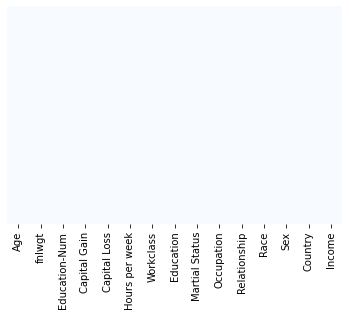

In [22]:
# Let's see if we have any missing data, luckily we don't!
sns.heatmap(X_train.isna(), yticklabels = False, cbar = False, cmap="Blues")
plt.show()

## Visualize Categorical Features

In [23]:
# this is important since we might have rare labels which isnt good for grouping customers; the numeric equivalent would be outliers
for category in categorical_columns:
    print('Value counts in category {}: \n{}'.format(category, X_train[category].value_counts()))

Value counts in category Workclass: 
Private             7344
Self-emp-not-inc     770
Local-gov            661
State-gov            388
Self-emp-inc         340
Federal-gov          261
Without-pay            4
Name: Workclass, dtype: int64
Value counts in category Education: 
HS-grad         3165
Some-college    2139
Bachelors       1601
Masters          525
Assoc-voc        439
11th             383
Assoc-acdm       322
10th             271
7th-8th          177
9th              165
Prof-school      159
12th             126
Doctorate        122
5th-6th           96
1st-4th           61
Preschool         17
Name: Education, dtype: int64
Value counts in category Martial Status: 
Married-civ-spouse       4467
Never-married            3250
Divorced                 1298
Separated                 324
Widowed                   293
Married-spouse-absent     129
Married-AF-spouse           7
Name: Martial Status, dtype: int64
Value counts in category Occupation: 
Exec-managerial      1847
Craf

## Encode Rare Labels

In [24]:
rare_encoder = RareLabelEncoder(tol=0.05, n_categories=10)
X_train[categorical_columns] = rare_encoder.fit_transform(X_train[categorical_columns])
X_train[categorical_columns].head()

The number of unique categories for variable Workclass is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable Martial Status is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable Relationship is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable Race is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
The number of unique categories for variable Income is less than that indicated in n_categories. Thus, all categories will be considered frequent


,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
20904,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,<=50K
47239,Private,Masters,Married-civ-spouse,Rare,Husband,Asian-Pac-Islander,Male,Rare,>50K
29209,Private,HS-grad,Married-civ-spouse,Rare,Husband,White,Male,United-States,<=50K
22674,Private,HS-grad,Never-married,Machine-op-inspct,Own-child,White,Male,United-States,<=50K
11463,Private,HS-grad,Never-married,Rare,Not-in-family,White,Male,United-States,<=50K


In [25]:
# Save rare label encoder
with open('../artifacts/rare_encoder.pickle', 'wb') as filename:
    pickle.dump(rare_encoder, filename)

## Visualize Numerical Features

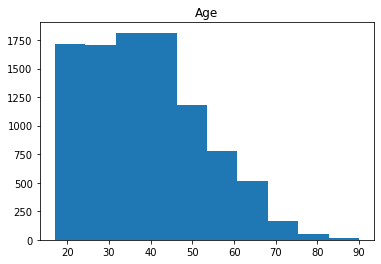

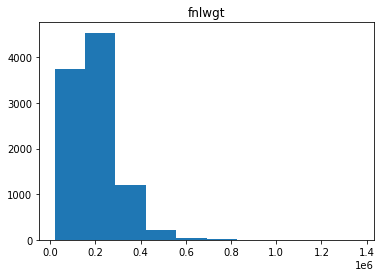

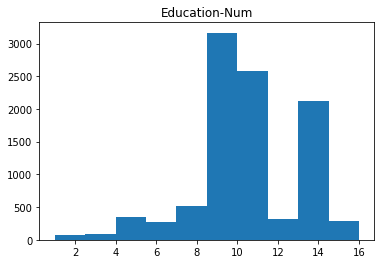

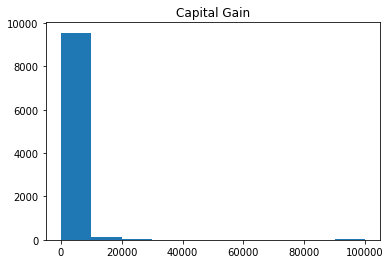

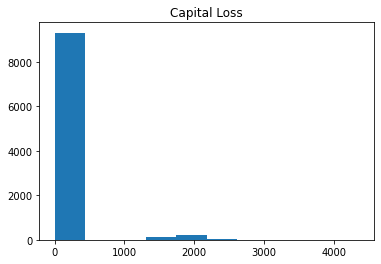

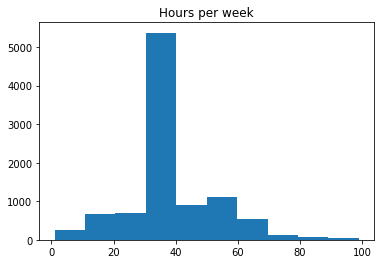

In [26]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

## Remove Outliers

In [27]:
# set up the capper
capper = Winsorizer(
    capping_method='gaussian', 
    tail='right', 
    fold=3, 
    variables=numeric_columns)

In [ ]:
# fit the capper
X_train[numeric_columns] = capper.fit_transform(X_train[numeric_columns])
X_train.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
20904,20.0,194630.0,9.0,3781.0,0.000000,50.0,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,<=50K
47239,41.0,143003.0,14.0,0.0,1290.295683,45.0,Private,Masters,Married-civ-spouse,Rare,Husband,Asian-Pac-Islander,Male,Rare,>50K
29209,31.0,210562.0,9.0,0.0,0.000000,65.0,Private,HS-grad,Married-civ-spouse,Rare,Husband,White,Male,United-States,<=50K
22674,19.0,67759.0,9.0,0.0,0.000000,43.0,Private,HS-grad,Never-married,Machine-op-inspct,Own-child,White,Male,United-States,<=50K
11463,45.0,241350.0,9.0,0.0,0.000000,40.0,Private,HS-grad,Never-married,Rare,Not-in-family,White,Male,United-States,<=50K


In [ ]:
# Save capper 
with open('../artifacts/capper.pickle', 'wb') as filename:
    pickle.dump(capper, filename)

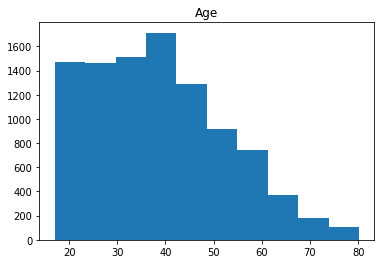

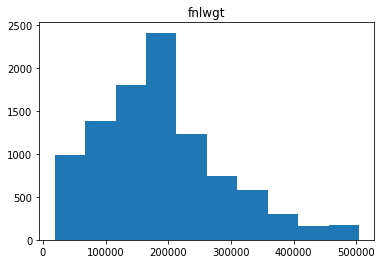

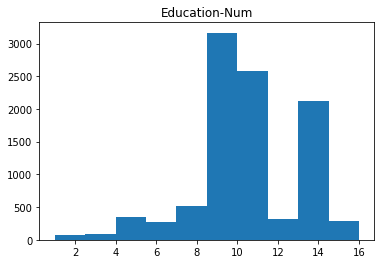

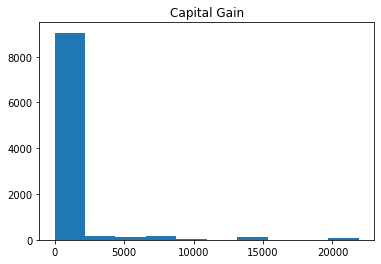

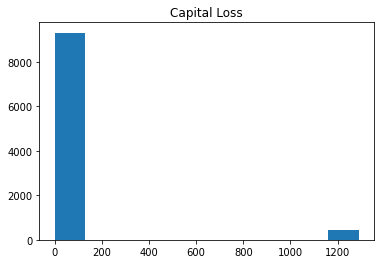

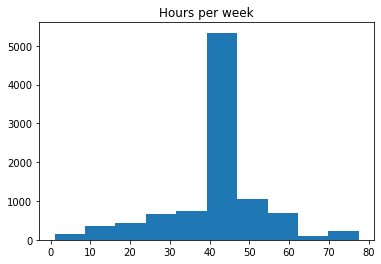

In [ ]:
# plot the distributions
for col in numeric_columns:
    plt.hist(X_train[col])
    plt.title(col)
    plt.show()

# Calculate Customer Similarity using Gower´s Distance

In [ ]:
%%time
distance_matrix = gower.gower_matrix(X_train)

CPU times: total: 1min 26s
Wall time: 1min 26s


In [ ]:
distance_matrix.shape

(9768, 9768)

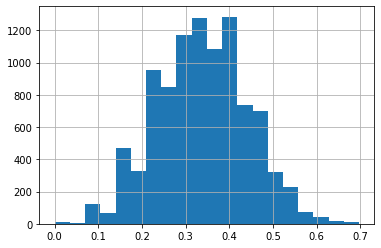

In [ ]:
customer = 3
plt.hist(distance_matrix[:,customer], bins=20)
plt.grid()
plt.show()

In [ ]:
# let´s choose a cut-off gower´s distance of e.g. 0.2
gower_cutoff = 0.2  

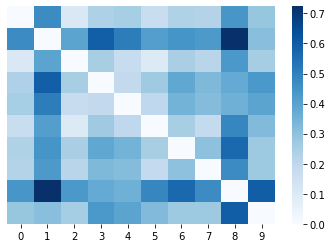

In [ ]:
# plot the similarity matrix as heatmap
sns.heatmap(
    distance_matrix[:10,:10], 
    yticklabels = False, 
    cbar = True, 
    cmap="Blues")
plt.show()

In [ ]:
# find the top-n customers similar to a particular customer
customer=100
top_n = gower.gower_topn(
    X_train.iloc[customer:customer+1,:], 
    X_train.iloc[:,], 
    n = 5)
top_n

{'index': array([ 100, 5463, 9399,  139, 2509], dtype=int64),
 'values': array([0.        , 0.08516712, 0.15786119, 0.18151745, 0.18382479],
       dtype=float32)}

In [ ]:
top_n['index']

array([ 100, 5463, 9399,  139, 2509], dtype=int64)

In [ ]:
X_train.iloc[top_n['index'],:]

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
36789,57.0,133201.0,4.0,0.0,1290.295683,40.0,Private,Rare,Divorced,Craft-repair,Unmarried,White,Male,Rare,<=50K
30299,42.0,152676.0,4.0,0.0,0.000000,40.0,Private,Rare,Divorced,Craft-repair,Unmarried,White,Male,Rare,<=50K
42208,47.0,234994.0,4.0,0.0,0.000000,40.0,Private,Rare,Separated,Craft-repair,Unmarried,White,Male,Rare,<=50K
8867,34.0,56121.0,7.0,0.0,0.000000,40.0,Private,Rare,Divorced,Craft-repair,Unmarried,White,Male,United-States,<=50K
7032,27.0,151382.0,4.0,0.0,974.000000,40.0,Private,Rare,Divorced,Machine-op-inspct,Unmarried,White,Male,United-States,<=50K


# DBScan Clustering

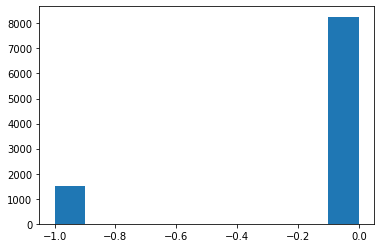

CPU times: total: 625 ms
Wall time: 627 ms


In [ ]:
%%time
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.1, 
                        min_samples=25, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
#plt.ylim(0,1000)
plt.show()

In [ ]:
# Compute Cluster Quality using Silhouette Score

silhouette_score(
    X=distance_matrix, 
    labels=dbscan_cluster.labels_, 
    metric="precomputed")

0.1620112

In [ ]:
%%time
# lets try different hyperparameters and count the cluster numbers; we dont want like 100 cluster but we do want maybe more than 2 clusters

results_list = []
eps_range = np.arange(.025, 0.25, .0125)
min_sample_range = np.arange(5, 50, 2)

for eps in eps_range:
    for min_samples in min_sample_range:

        # Configuring the parameters of the clustering algorithm
        dbscan_cluster = DBSCAN(eps=eps, 
                                min_samples=min_samples, 
                                metric="precomputed",
                                n_jobs=-1)

        # Fitting the clustering algorithm
        dbscan_cluster.fit(distance_matrix)

        # count the number of clusters different from noise i.e. labeled -1
        num_cluster_detected = len(np.unique(dbscan_cluster.labels_[np.where(dbscan_cluster.labels_ >= 0)]))
        # count the number of datapoints i.e. customers labeled as noise i.e. -1
        num_noise_data = list(dbscan_cluster.labels_).count(-1)
        # calculate cluster quality using the silhouette score
        cluster_quality = silhouette_score(X=distance_matrix, 
                                           labels=dbscan_cluster.labels_, 
                                           metric="precomputed")
        

        # save results
        results_list.append([eps, min_samples, cluster_quality, num_cluster_detected, num_noise_data])

In [ ]:
results_list

[[0.025, 5, -0.1675002, 222, 5973],
 [0.025, 7, -0.22653246, 143, 6555],
 [0.025, 9, -0.26788288, 104, 6991],
 [0.025, 11, -0.30352637, 83, 7304],
 [0.025, 13, -0.33153582, 64, 7623],
 [0.025, 15, -0.35540986, 52, 7872],
 [0.025, 17, -0.37198195, 45, 8059],
 [0.025, 19, -0.38483235, 37, 8263],
 [0.025, 21, -0.39733794, 31, 8469],
 [0.025, 23, -0.40423808, 19, 8777],
 [0.025, 25, -0.4076334, 17, 8842],
 [0.025, 27, -0.40640062, 15, 8922],
 [0.025, 29, -0.407169, 14, 8964],
 [0.025, 31, -0.38870418, 11, 9076],
 [0.025, 33, -0.38400245, 9, 9161],
 [0.025, 35, -0.34171322, 7, 9249],
 [0.025, 37, -0.33461648, 6, 9304],
 [0.025, 39, -0.26084188, 4, 9393],
 [0.025, 41, -0.2625539, 4, 9400],
 [0.025, 43, -0.26289728, 4, 9402],
 [0.025, 45, -0.26531008, 4, 9410],
 [0.025, 47, -0.25877985, 3, 9457],
 [0.025, 49, -0.25897732, 3, 9458],
 [0.037500000000000006, 5, -0.02347268, 306, 4818],
 [0.037500000000000006, 7, -0.09088617, 211, 5406],
 [0.037500000000000006, 9, -0.14179122, 157, 5892],
 [0.037

In [ ]:
clustering_results_df = pd.DataFrame(results_list, columns = ("eps", "min_samples", "cluster_quality", "num_clusters", "num_noise_data"))
clustering_results_df

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


,eps,min_samples,cluster_quality,num_clusters,num_noise_data
0,0.0250,5,-0.167500,222,5973
1,0.0250,7,-0.226532,143,6555
2,0.0250,9,-0.267883,104,6991
3,0.0250,11,-0.303526,83,7304
4,0.0250,13,-0.331536,64,7623
...,...,...,...,...,...
409,0.2375,41,0.335852,1,3
410,0.2375,43,0.334768,1,4
411,0.2375,45,0.334768,1,4
412,0.2375,47,0.350782,1,5


In [ ]:
nclusters = 3
db_config = clustering_results_df[clustering_results_df["num_clusters"] == nclusters].sort_values(by="cluster_quality", ascending=False)
db_config 

,eps,min_samples,cluster_quality,num_clusters,num_noise_data
122,0.0875,19,0.013418,3,2313
104,0.0750,29,-0.008191,3,5366
154,0.1000,37,-0.013494,3,1853
105,0.0750,31,-0.016166,3,5498
155,0.1000,39,-0.025118,3,1907
156,0.1000,41,-0.029509,3,1989
157,0.1000,43,-0.035816,3,2037
158,0.1000,45,-0.036636,3,2108
21,0.0250,47,-0.258780,3,9457
22,0.0250,49,-0.258977,3,9458


0.088 19


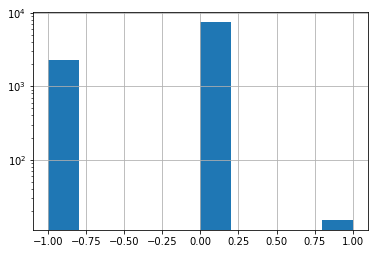

0.075 29


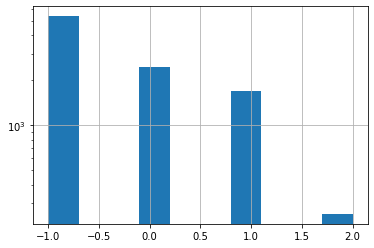

0.1 37


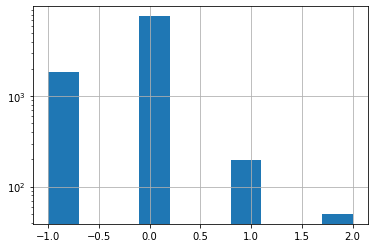

0.075 31


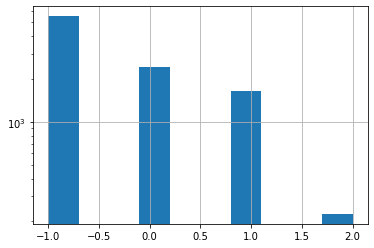

0.1 39


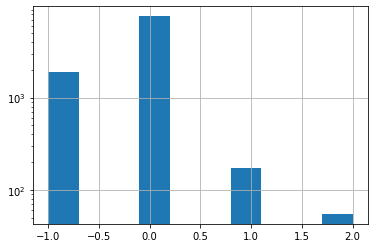

0.1 41


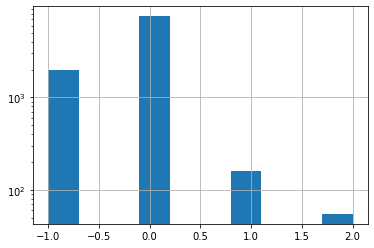

0.1 43


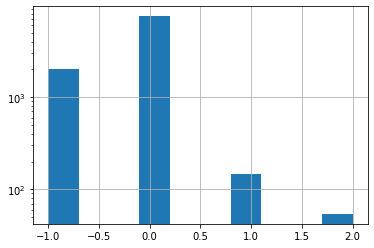

0.1 45


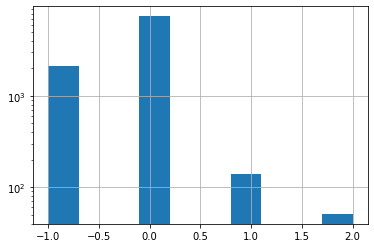

0.025 47


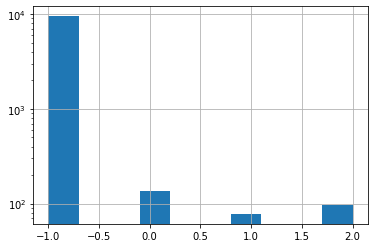

0.025 49


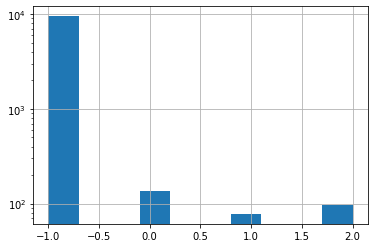

In [ ]:
for conf in np.array(db_config[['eps', 'min_samples']]):
    eps = np.round(conf[0],3)
    min_samples = int(conf[1])
    print(eps, min_samples)

    # Configuring the parameters of the clustering algorithm
    dbscan_cluster = DBSCAN(eps=eps, 
                            min_samples=min_samples, 
                            metric="precomputed",
                            n_jobs=-1)

    # Fitting the clustering algorithm
    dbscan_cluster.fit(distance_matrix)

    plt.hist(dbscan_cluster.labels_) 
    plt.yscale('log')
    plt.grid()
    plt.show()

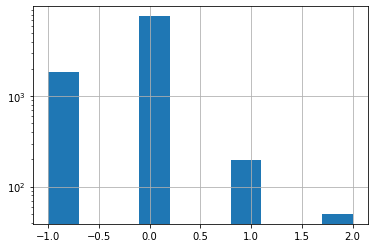

In [ ]:
# Configuring the parameters of the clustering algorithm
dbscan_cluster = DBSCAN(eps=0.1, 
                        min_samples=37, 
                        metric="precomputed",
                        n_jobs=-1)

# Fitting the clustering algorithm
dbscan_cluster.fit(distance_matrix)

plt.hist(dbscan_cluster.labels_) 
plt.yscale('log')
plt.grid()
plt.show()

In [ ]:
# Adding the results to a new column in the dataframe
X_train["cluster"] = dbscan_cluster.labels_
X_train.head()

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income,cluster
20904,20.0,194630.0,9.0,3781.0,0.000000,50.0,Private,HS-grad,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States,<=50K,0
47239,41.0,143003.0,14.0,0.0,1290.295683,45.0,Private,Masters,Married-civ-spouse,Rare,Husband,Asian-Pac-Islander,Male,Rare,>50K,-1
29209,31.0,210562.0,9.0,0.0,0.000000,65.0,Private,HS-grad,Married-civ-spouse,Rare,Husband,White,Male,United-States,<=50K,0
22674,19.0,67759.0,9.0,0.0,0.000000,43.0,Private,HS-grad,Never-married,Machine-op-inspct,Own-child,White,Male,United-States,<=50K,0
11463,45.0,241350.0,9.0,0.0,0.000000,40.0,Private,HS-grad,Never-married,Rare,Not-in-family,White,Male,United-States,<=50K,0


In [ ]:
# Relabel Clusters starting from 0
X_train["cluster"] = X_train["cluster"] + 1

# Train Model on Cluster Label

### One Hote Encode

In [ ]:
enc = OneHotEncoder(
    handle_unknown='ignore',
    sparse=False,
    drop='first')

In [ ]:
enc.fit(X_train[categorical_columns])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

In [ ]:
X_train_hot_enc = enc.transform(X_train[categorical_columns])

In [ ]:
# Save one hot encoder
with open('../artifacts/enc.pickle', 'wb') as filename:
    pickle.dump(enc, filename)

In [ ]:
X_train_cat_hotenc = pd.DataFrame(X_train_hot_enc, columns=enc.get_feature_names_out()) 
X_train_cat_hotenc.index = X_train.index 
X_train_cat_hotenc.head()

,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,Workclass_State-gov,Workclass_Without-pay,Education_HS-grad,Education_Masters,Education_Rare,Education_Some-college,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Male,Country_United-States,Income_>50K
20904,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
47239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
29209,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
22674,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
11463,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
X_train_hotenc = pd.concat([X_train[numeric_columns], X_train_cat_hotenc], axis=1) 
X_train_hotenc

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_Local-gov,Workclass_Private,Workclass_Self-emp-inc,Workclass_Self-emp-not-inc,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Race_Asian-Pac-Islander,Race_Black,Race_Other,Race_White,Sex_Male,Country_United-States,Income_>50K
20904,20.0,194630.0,9.0,3781.0,0.000000,50.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
47239,41.0,143003.0,14.0,0.0,1290.295683,45.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
29209,31.0,210562.0,9.0,0.0,0.000000,65.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
22674,19.0,67759.0,9.0,0.0,0.000000,43.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
11463,45.0,241350.0,9.0,0.0,0.000000,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,53.0,64322.0,4.0,0.0,0.000000,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
15377,39.0,147548.0,9.0,0.0,0.000000,40.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
17730,33.0,108116.0,9.0,0.0,0.000000,40.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
28030,19.0,36012.0,9.0,0.0,0.000000,40.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [ ]:
y = X_train['cluster']

In [ ]:
# create a train/test split
X_train_hotenc_train, X_train_hotenc_test, y_train, y_test = train_test_split(
    X_train_hotenc, 
    y, 
    test_size=0.3, 
    random_state=123)

# Training Sklearn Random Forest b/c of Multiclass Shap Compatibility!

In [ ]:
clf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    min_samples_split=3,
    min_samples_leaf=3,
    max_features='log2', 
    random_state=123)

In [ ]:
clf.fit(X_train_hotenc_train, y_train)

RandomForestClassifier(max_features='log2', min_samples_leaf=3,
                       min_samples_split=3, random_state=123)

In [ ]:
# evaluate accuracy on training set
clf.score(X_train_hotenc_train, y_train)

0.9584613134415679

In [ ]:
# evaluate accuracy on test set
clf.score(X_train_hotenc_test, y_test)

0.9208461276015012

In [ ]:
pred = clf.predict(X_train_hotenc_train)
pred

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

### Tuning Random Forest

In [ ]:
parameters = {
    'n_estimators': (50, 100, 200),
    'max_depth': (3, 5, None),
    'min_samples_split': (1, 3, 6),
    'min_samples_leaf': (1, 3, 6),
    }

model = GridSearchCV(
    clf, 
    parameters,
    cv=3, 
    n_jobs =-1)

In [ ]:
model.fit(X_train_hotenc_train, y_train)


81 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
81 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\joblib\parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\joblib\parallel.py

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_features='log2',
                                              min_samples_leaf=3,
                                              min_samples_split=3,
                                              random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': (3, 5, None),
                         'min_samples_leaf': (1, 3, 6),
                         'min_samples_split': (1, 3, 6),
                         'n_estimators': (50, 100, 200)})

In [ ]:
# evaluate accuracy on training set
model.score(X_train_hotenc_train, y_train)

0.9997074740383209

In [ ]:
# evaluate accuracy on test set
model.score(X_train_hotenc_test, y_test)

0.9334698055271239

In [ ]:
# predict
model.predict(X_train_hotenc_train)

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

In [ ]:
model.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200}

In [ ]:
# Save the trained classifier
with open('../artifacts/model.pickle', 'wb') as filename:
    pickle.dump(model, filename)

# Model Evaluation

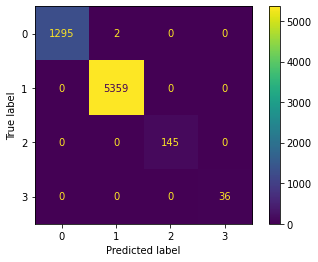

In [ ]:
# plot confusion matrix for training data
cm = confusion_matrix(y_train, model.predict(X_train_hotenc_train), labels=clf.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,                            
    display_labels=clf.classes_)
disp.plot()
plt.show()

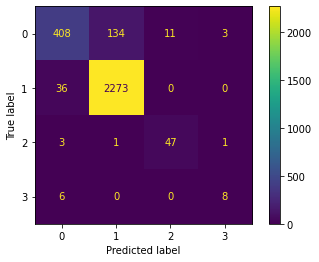

In [ ]:
# plot confusion matrix for training data
cm = confusion_matrix(y_test, model.predict(X_train_hotenc_test), labels=clf.classes_)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,                            
    display_labels=clf.classes_)
disp.plot()
plt.show()